# Test Seismic Transformer model

*Author: Jason Jiang (Xunfun Lee)*

*Date: 2023.12.06*

## 0. Device

In [1]:
import torch
# device
if torch.cuda.is_available():
    device = "cuda"
    print("CUDA is available")
    print("CUDA device numbers: ", torch.cuda.device_count())
    !nvidia-smi
elif torch.backends.mps.is_available():
    device = "mps"
    print("MPS is available")
else:
    device = "cpu"
    print("No GPU found, using CPU")

device

CUDA is available
CUDA device numbers:  1
Fri Dec 15 19:26:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  Off |
|  0%   51C    P8    34W / 480W |   1390MiB / 24564MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                              

'cuda'

## 1. Load the model first

In [2]:
from PythonScripts.utility import LoadModel

In [3]:
# SeT = LoadModel("SeT_25_HS_768_Layer_4_Head_8_Epoch_20_Acc_0.92_F1_0.79_Model.pth")
import os
map_location=torch.device(device)
model_path = os.path.join("Models", 'SeT_1_HS_768_Layer_4_Head_12_Epoch_20_Acc_0.92_F1_0.82_Model.pth')
model = torch.load(model_path, map_location=map_location)
SeT = model.to(device)

## 2. Prepare an example of ground motion

### 2.1 Plot the ground motion

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_earthquake_data(excel_file):
    # read the data
    df = pd.read_excel(excel_file, usecols=[0, 1], header=None)

    # get the data
    time_data = df[0].tolist()  # time
    earthquake_data = df[1].tolist()  # data

    print(len(time_data))

    # plot the data
    plt.figure(figsize=(15, 5))
    plt.plot(time_data, earthquake_data, marker='o', linestyle='-')
    plt.title('Acceleration over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.grid(True)
    plt.legend(['Acceleration'])
    plt.show()

4001


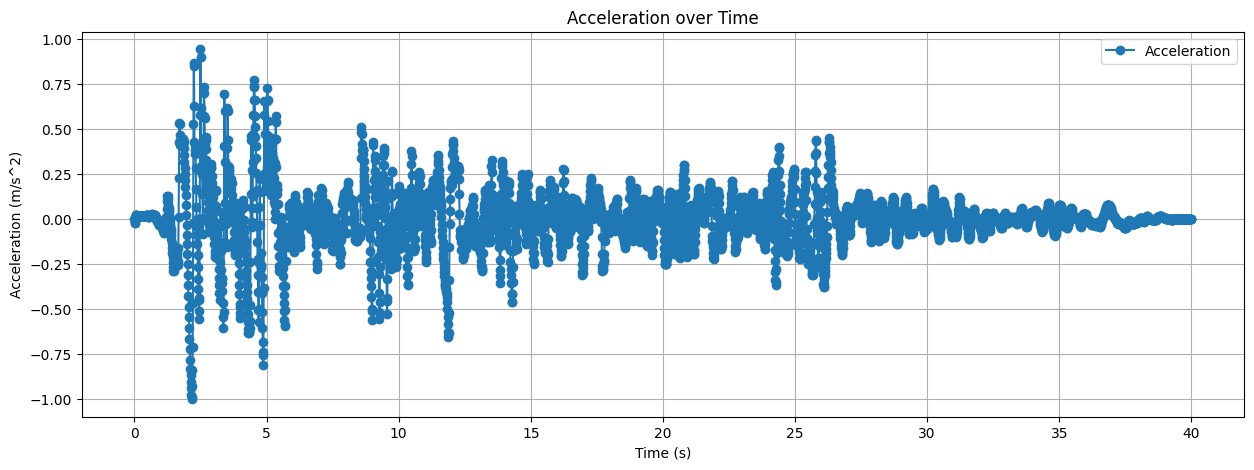

In [5]:
import os

# Excel Path
gm_data = 'El-Centro.xlsx'
file_path = os.path.join("Data", "GM_Example", gm_data)

# Plot
plot_earthquake_data(file_path)


### 2.2 Turn the data to tensor and shape to feed the model

El-Centro has 4,001 points while our model only take 3,000 max. So we have to cut the data first. Then we need to shape it into tensor with [1, 3000, 1] to feed the model. However, we can fine that El-Centro is 100Hz sample rate for 40s while our model using 50Hz to train, which means we can't just cut the original data and feed it into the model.

We have to lower the sample rate down to 2,000 points and padding 1,000 "0" to the curve as we prepare for the training.

In [6]:
import pandas as pd
import torch

# raad the excel file
df = pd.read_excel(file_path, usecols=[1], header=None)  # 仅读取data列

# cut the last of the data [4001] --> [4000]
data_without_last = df.iloc[:-1, 0]

# [4000] --> [2000]
resampled_data = data_without_last.iloc[::2].tolist()

assert len(resampled_data) == 2000, "Length resampled_data ({resample_data} is not equal 2,000)"

# padding 0 to the data
# padded_data = resampled_data + [0] * 1000
padded_data = [0] * 1000 + resampled_data 
# padded_data = [0] * 500 + resampled_data + [0] * 500

# Tensor[1, 3000, 1]
data_tensor = torch.tensor(padded_data, dtype=torch.float).view(1, -1, 1)

data_tensor.shape  # torch.Size([1, 3000, 1])

torch.Size([1, 3000, 1])

### 2.3 Visualize the data after precessing

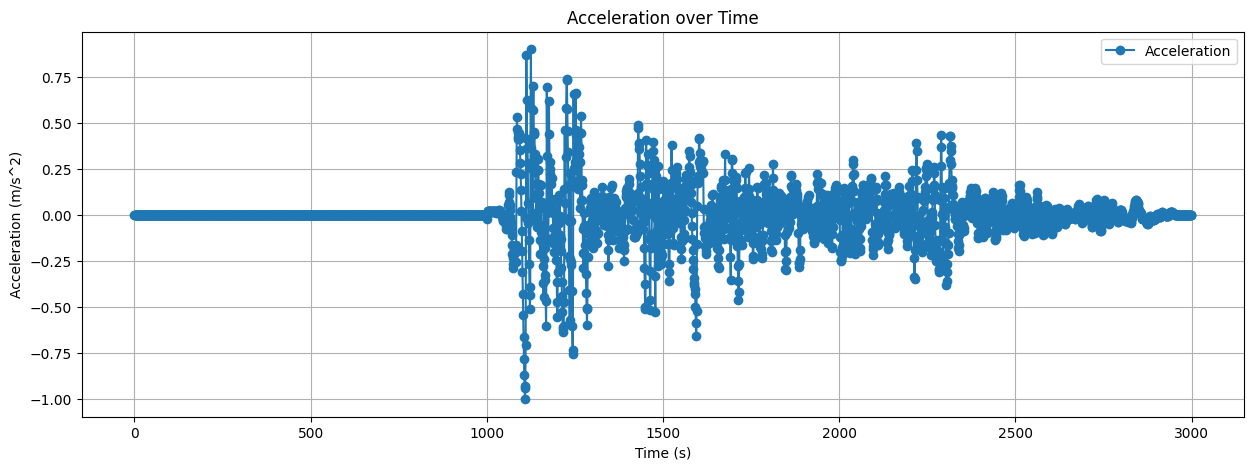

In [7]:
times = []
for i in range(len(padded_data)):
    i += 0.2
    times.append(i)

plt.figure(figsize=(15, 5))
plt.plot(times, padded_data, marker='o', linestyle='-')
plt.title('Acceleration over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.grid(True)
plt.legend(['Acceleration'])
plt.show()

### 2.4 Split the data

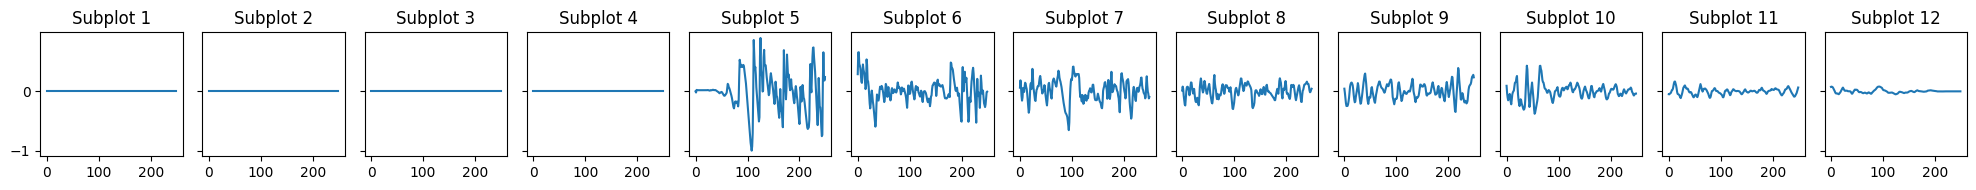

In [8]:
# number of sub plots = Length / patch_size
num_subplots = 3000 / 250

# each points of the subplot
points_per_subplot = int(3000 // num_subplots)

# create the figure and subplot
fig, axes = plt.subplots(nrows=1, ncols=int(num_subplots), figsize=(20, 2), sharex=True, sharey=True)

# create every subplot
for i in range(int(num_subplots)):
    start_index = i * points_per_subplot
    end_index = (i + 1) * points_per_subplot if i < num_subplots - 1 else 3000
    axes[i].plot(padded_data[start_index:end_index])
    axes[i].set_title(f"Subplot {i + 1}")

# gap between subplot
plt.tight_layout()

# show the image
plt.show()

## 3. Pass the ground motion to the model

In [9]:
from PythonScripts.data_preparation import FastFourierTransform

# transformdata = FastFourierTransform(padded_data)
gm_data_tensor = torch.tensor(padded_data, dtype=torch.float).view(1, -1, 1)
gm_data_tensor.shape

FFT_data = FastFourierTransform(gm_data_tensor)

FFT_data = FFT_data.squeeze(2)

FFT_data.shape

torch.Size([1, 1500])

In [10]:
# turn the model and data into tarrget device
SeT = SeT.to(device)
data_tensor = data_tensor.to(device)
FFT_data = FFT_data.to(device)

with torch.inference_mode():  # 使用 inference_mode 以减少内存占用
    y_logit = SeT(x=data_tensor,mask=None,frequency=FFT_data)
    probabilities = torch.softmax(y_logit, dim=1)  # 计算每个类别的概率
    predicted_labels = torch.argmax(probabilities, dim=1)  # 获取最高概率的标签

    # 如果你想输出具体的概率值
    max_probabilities, predicted_labels = probabilities.max(dim=1)  # 获取最高概率及其对应的标签
    print("Predicted labels:", predicted_labels)
    print("Max probabilities:", max_probabilities)

Predicted labels: tensor([0], device='cuda:0')
Max probabilities: tensor([1.], device='cuda:0')


## 4. Check the attention_weights

In [11]:
SeT.attention_weights_list[-1].shape, len(SeT.attention_weights_list)

(torch.Size([1, 15, 15]), 4)

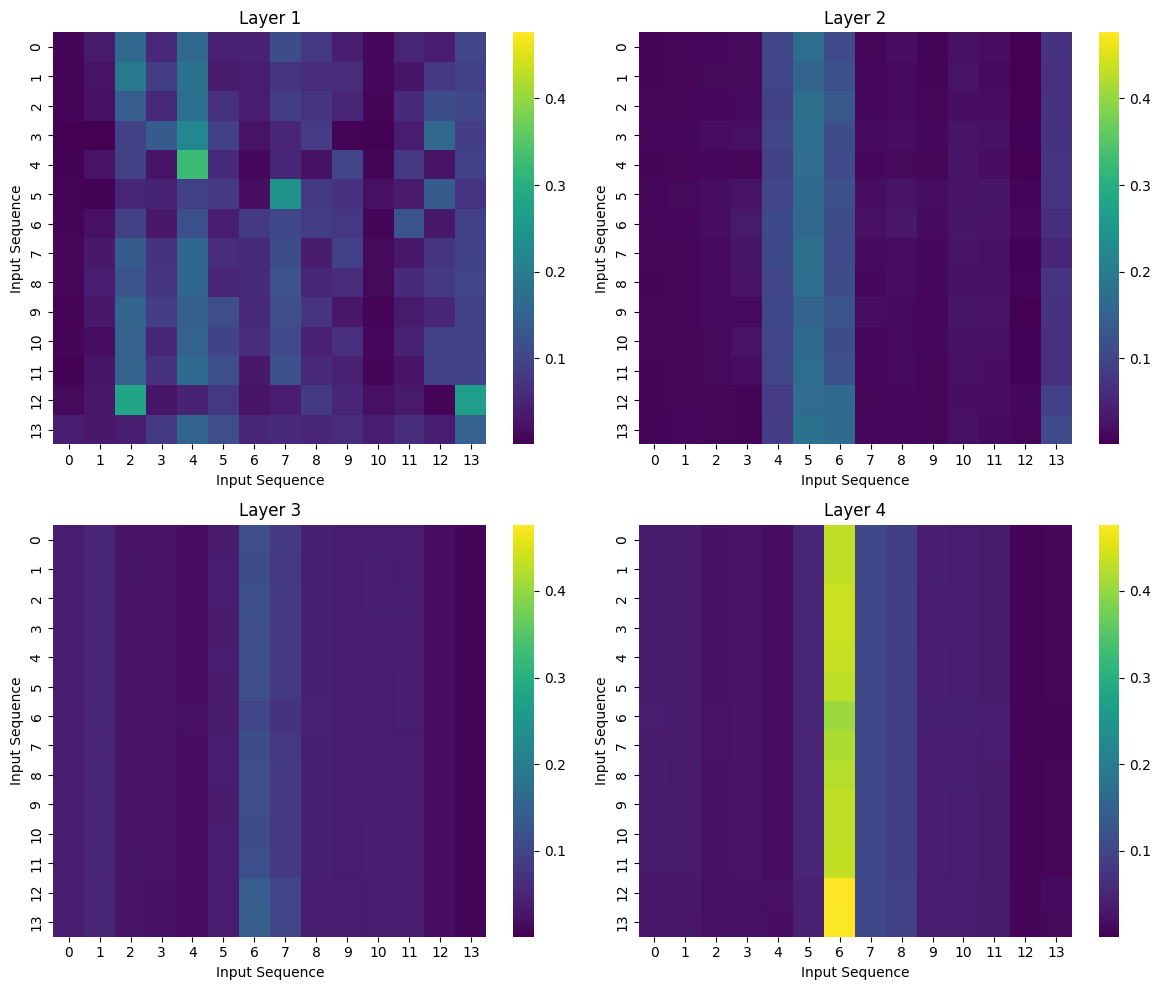

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

attention_weights_list = SeT.attention_weights_list  # len(SeT.attention_weights_list) = 4, SeT.attention_weights_list[-1].shape = torch.Size([1, 13, 13])

global_min = np.inf  # 设置一个极大值
global_max = -np.inf  # 设置一个极小值
for layer_attention in attention_weights_list:
    attn_matrix = layer_attention[0, 1:, 1:].detach().cpu().numpy()
    global_min = min(global_min, attn_matrix.min())
    global_max = max(global_max, attn_matrix.max())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

for layer_idx, layer_attention in enumerate(attention_weights_list):
    attn_matrix = layer_attention[0, 1:, 1:].detach().cpu().numpy()

    row_idx = layer_idx // 2
    col_idx = layer_idx % 2

    sns.heatmap(attn_matrix, cmap='viridis', annot=False, fmt=".2f",
                vmin=global_min, vmax=global_max, ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_title(f'Layer {layer_idx + 1}')

    axes[row_idx, col_idx].set_xlabel('Input Sequence')
    axes[row_idx, col_idx].set_ylabel('Input Sequence')

# 调整子图之间的空间
plt.tight_layout()
plt.show()

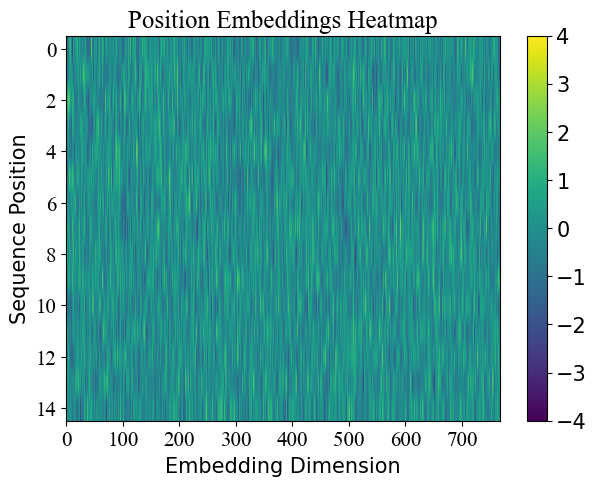

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming SeT is your model instance, it has already been loaded onto the GPU device
# Get the position embedding tensor, make sure to remove gradient tracking, and transfer it to the CPU
position_embeddings = SeT.position_embedding.squeeze(0)
position_embeddings = position_embeddings.detach().cpu().numpy()

titlesize = 18
fontsize = 15

# Create a new figure
plt.figure(figsize=(7, 5))

# Use imshow to create a heatmap
heatmap = plt.imshow(position_embeddings, cmap='viridis', aspect='auto', vmin=-4, vmax=4)

# Add a color bar at the right
cbar = plt.colorbar(heatmap)
cbar.ax.tick_params(labelsize=15)  # Set the font size of the color bar

# Set the main title and increase the font size
plt.title('Position Embeddings Heatmap', fontsize=18, fontname='Times New Roman')

# Adjust the y-axis to make it easier to read
plt.yticks(rotation=0, fontsize=15, fontname='Times New Roman')  # Adjust the font size as needed, rotation=0 ensures that the y-axis labels do not rotate and are horizontal
plt.xticks(rotation=0, fontsize=15, fontname='Times New Roman')  # Adjust the font size as needed, rotation=0 ensures that the y-axis labels do not rotate and are horizontal
plt.xlabel('Embedding Dimension', fontsize=fontsize)
plt.ylabel('Sequence Position', fontsize=fontsize)
# Save the plot in SVG format
plt.savefig('position_embeddings_heatmap.svg', format='svg')

# Display the plot
plt.show()

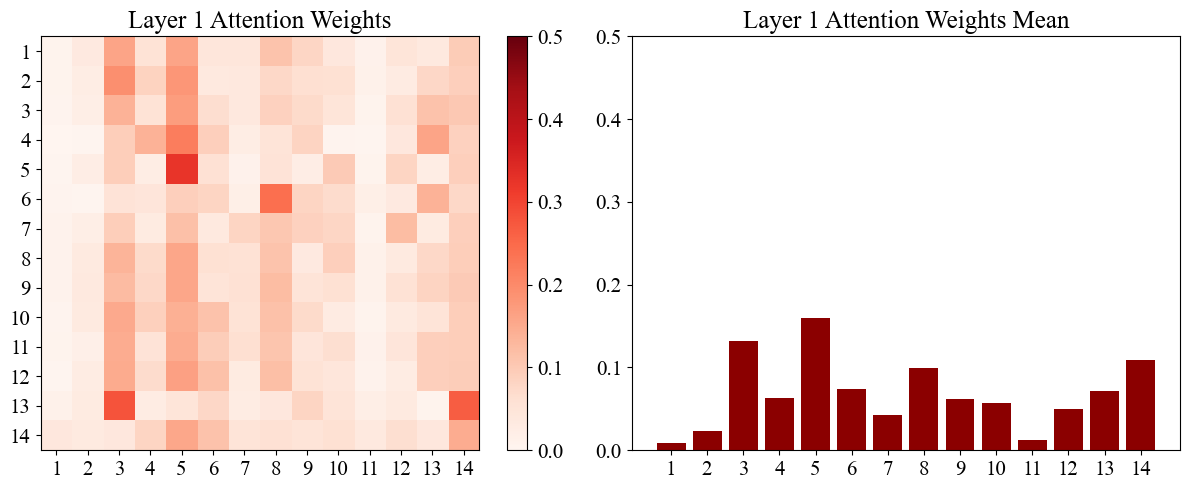

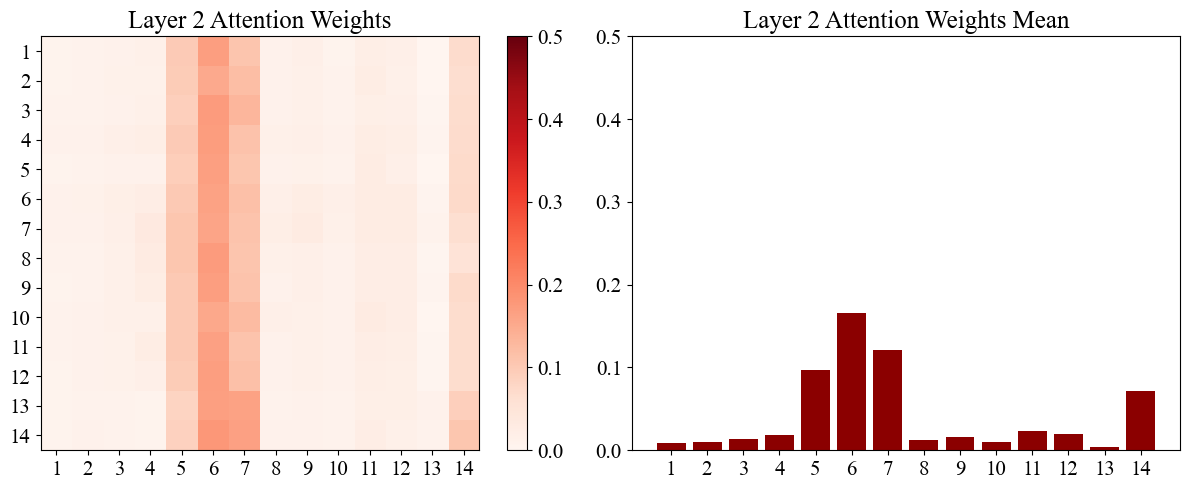

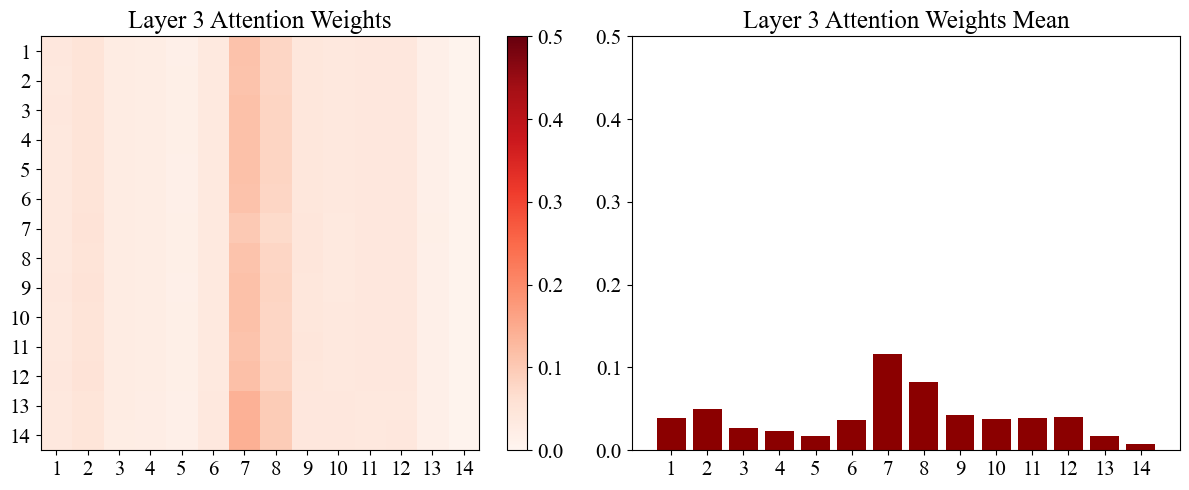

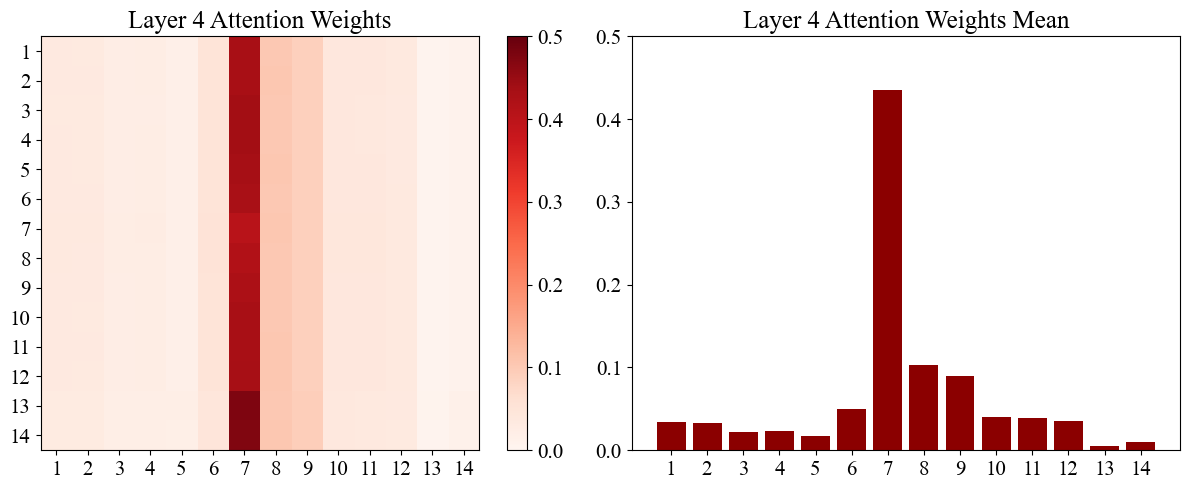

In [20]:
import matplotlib.pyplot as plt
import numpy as np

attention_weights_list = SeT.attention_weights_list  # len(SeT.attention_weights_list) = 4, SeT.attention_weights_list[-1].shape = torch.Size([1, 13, 13])

# trimmed_attention_matrix = [aw.squeeze(0).cpu().detach().numpy() for aw in attention_weights_list] # 假设attention_weights_list中的每个元素都有形状[1, 13, 13]
trimmed_attention_matrix = [aw.squeeze(0).cpu().detach().numpy()[1:, 1:] for aw in SeT.attention_weights_list] # 从第2行和第2列开始取值

# 设置全局字体为新罗马字体(Times New Roman)
plt.rcParams['font.family'] = 'Times New Roman'

# 循环画出所有热力图和柱状图
for i, aw in enumerate(trimmed_attention_matrix):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 为每对热力图和柱状图创建新的Figure和Axes

    # 热力图
    heatmap = axs[0].imshow(aw, cmap='Reds', aspect='auto', vmin=0, vmax=0.5)
    cbar = fig.colorbar(heatmap, ax=axs[0])
    cbar.ax.tick_params(labelsize=fontsize)  # 设置colorbar刻度字体大小
    axs[0].set_xticks(range(12+2))
    axs[0].set_xticklabels(range(1, 13+2), fontsize=fontsize)
    axs[0].set_yticks(range(12+2))
    axs[0].set_yticklabels(range(1, 13+2), fontsize=fontsize)
    axs[0].set_title(f'Layer {i+1} Attention Weights', fontsize=titlesize)

    # 柱状图
    means = aw.mean(axis=0)
    axs[1].bar(range(1, 13+2), means, color='darkred')
    axs[1].set_xticks(range(1, 13+2))
    axs[1].set_xticklabels(range(1, 13+2), fontsize=fontsize)
    axs[1].tick_params(axis='y', labelsize=fontsize)  # 设置y轴刻度字体大小
    axs[1].set_ylim(0, 0.5)
    axs[1].set_title(f'Layer {i+1} Attention Weights Mean', fontsize=titlesize)

    plt.tight_layout()
    # plt.show()
    # 保存图像的SVG版本
    
    plt.savefig(f'attention_weights_layer_{i+1}.svg', format='svg', bbox_inches='tight')
    # plt.close(fig)  # 关闭当前的Figure释放内存

Cosine Similarity Matrix:
 [[ 9.99999881e-01  4.33341302e-02  1.27003854e-02  1.51971150e-02
  -6.20946363e-02  4.54741530e-06  5.97339589e-03 -3.37967724e-02
  -2.13605873e-02 -8.03028233e-03 -1.70910917e-02  3.60255279e-02
   2.46826299e-02  6.46096617e-02  7.66064413e-03]
 [ 4.33341302e-02  1.00000000e+00  4.32773530e-02  6.29007220e-02
   6.71955151e-03 -2.38026138e-02 -6.67906366e-03  2.49070600e-02
   2.38381289e-02  6.53245822e-02  3.81189585e-02 -2.95063183e-02
  -2.34979391e-02  8.33081268e-03 -7.03750504e-03]
 [ 1.27003854e-02  4.32773530e-02  9.99999940e-01  4.91503626e-03
  -1.04973977e-03  2.80602183e-02 -7.09451661e-02  4.84003052e-02
  -3.24118137e-02 -1.12864841e-03 -5.67457452e-02  1.72070768e-02
  -4.78196554e-02  1.42900860e-02 -9.30874348e-02]
 [ 1.51971150e-02  6.29007220e-02  4.91503626e-03  1.00000000e+00
   3.63273323e-02  5.98105509e-03 -5.47645353e-02 -4.24079262e-02
  -3.09968367e-02 -2.69190781e-03 -1.24531221e-02  3.06703392e-02
  -1.07374974e-02 -3.1591475

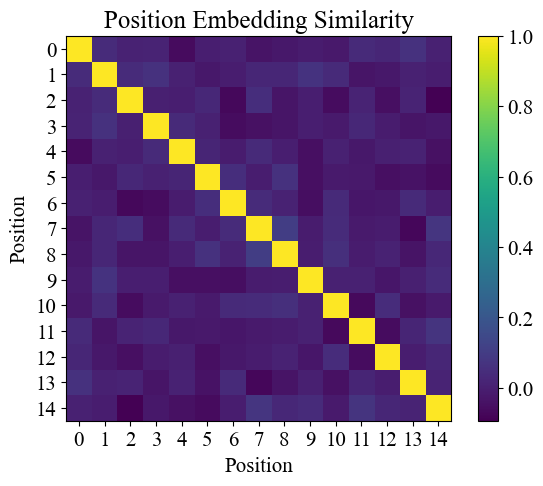

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 假设 transformer_model 是你的训练后的Transformer模型
SeT.eval()  # 将模型设置为评估模式

# 访问模型中的位置嵌入参数
position_embedding = SeT.position_embedding

# 以与上文中相同的方式计算位置嵌入的余弦相似性矩阵
normalized_pos_embeddings = F.normalize(position_embedding.squeeze(0), p=2, dim=-1)
cosine_similarity_matrix = torch.mm(normalized_pos_embeddings, normalized_pos_embeddings.t()).cpu().detach().numpy()

# 打印或分析位置嵌入的余弦相似性矩阵
print("Cosine Similarity Matrix:\n", cosine_similarity_matrix)

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# 假设你已经有了余弦相似性矩阵 cosine_similarity_matrix

# 创建热图
plt.figure(figsize=(7, 5))
plt.imshow(cosine_similarity_matrix, cmap='viridis')  # 使用viridis颜色映射
cbar = plt.colorbar()  # 显示颜色条
cbar.ax.tick_params(labelsize=fontsize)  # Set the fontsize of the color bar
# 设定轴标签和标题
plt.xlabel('Position', fontsize=fontsize)
plt.ylabel('Position', fontsize=fontsize)
plt.title('Position Embedding Similarity', fontsize=titlesize)

plt.xticks(range(13+2), fontsize=fontsize)
plt.yticks(range(13+2), fontsize=fontsize)

plt.savefig('Position Embedding Similarity.svg', format='svg')
plt.show()
